# NLP Sentiment Analysis

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Bidirectional,
    LSTM,
    Embedding,
    Flatten,
)

In [33]:
# Plot accuracy and loss
def plot_results(history):
    hist_df = pd.DataFrame(history.history)
    hist_df.columns=["loss", "accuracy", "val_loss", "val_accuracy"]
    hist_df.index = np.arange(1, len(hist_df)+1)

    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
    axs[0].plot(hist_df.val_accuracy, lw=3, label='Validation Accuracy')
    axs[0].plot(hist_df.accuracy, lw=3, label='Training Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].grid()
    axs[0].legend(loc=0)
    axs[1].plot(hist_df.val_loss, lw=3, label='Validation Loss')
    axs[1].plot(hist_df.loss, lw=3, label='Training Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].grid()
    axs[1].legend(loc=0)

    plt.show()

## Preprocessing

In [34]:
# Read txt files
test_data = pd.read_csv('data/test.txt', delimiter = "\t", names=['sentence'])
train_data = pd.read_csv('data/train.txt', delimiter = "\t", names=['sentence'])

print(train_data.shape, test_data.shape)
print(train_data.head())

(16000, 1) (2000, 1)
                                            sentence
0                    i didnt feel humiliated;sadness
1  i can go from feeling so hopeless to so damned...
2  im grabbing a minute to post i feel greedy wro...
3  i am ever feeling nostalgic about the fireplac...
4                         i am feeling grouchy;anger


In [35]:
# Column for label
train_data['feeling'] = train_data['sentence'].str.split(';').str[1]
test_data['feeling'] = test_data['sentence'].str.split(';').str[1]

# Remove label part in feature
train_data['sentence'] = train_data['sentence'].str.split(';').str[0]
test_data['sentence'] = test_data['sentence'].str.split(';').str[0]

train_data.head()

,sentence,feeling
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [36]:
# Check null values
null_values_train = train_data.isnull().sum()
null_values_test = test_data.isnull().sum()

print("Train data:\n", null_values_train)
print("\nTest data:\n", null_values_test)

Train data:
 sentence    0
feeling     0
dtype: int64

Test data:
 sentence    0
feeling     0
dtype: int64


In [37]:
# Check unique labels
unique_label_train = train_data['feeling'].unique()
unique_label_test = test_data['feeling'].unique()

num_label = len(unique_label_train)

print(sorted(unique_label_train))
print(sorted(unique_label_test))

['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']
['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']


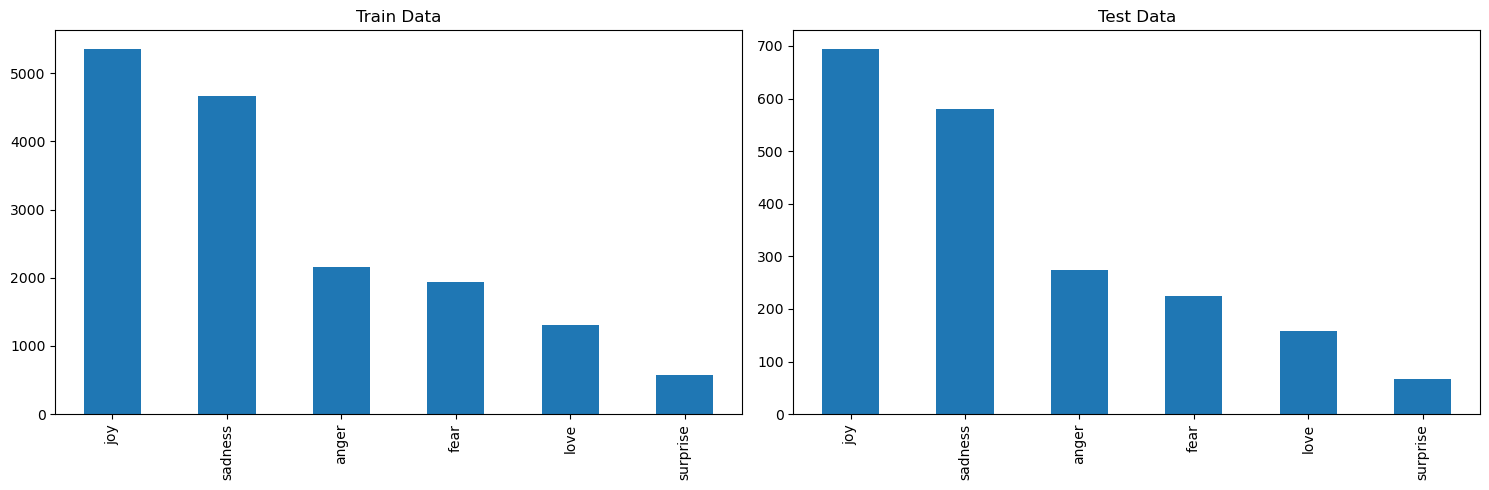

In [38]:
# Plot distribution of labels in train and test data
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

train_data['feeling'].value_counts().plot(kind='bar', ax=axes[0], title='Train Data')
test_data['feeling'].value_counts().plot(kind='bar', ax=axes[1], title='Test Data')

plt.tight_layout()
plt.show()

In [39]:
# Convert to list
train_sentences = train_data['sentence'].tolist()
train_labels = train_data['feeling'].tolist()

test_sentences = test_data['sentence'].tolist()
test_labels = test_data['feeling'].tolist()
  
len(train_sentences), len(test_sentences)


(16000, 2000)

In [40]:
# One-Hot Encode labels
encoder = LabelEncoder()

train_labels_encoded = to_categorical(encoder.fit_transform(train_labels))
test_labels_encoded = to_categorical(encoder.transform(test_labels))

train_labels_encoded

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)

In [41]:
# Tokenizer
vocab_size = 10000

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

print(len(train_sequences), len(test_sequences))
print(len(word_index))
print(list(word_index.items())[:10])

16000 2000
15213
[('<OOV>', 1), ('i', 2), ('feel', 3), ('and', 4), ('to', 5), ('the', 6), ('a', 7), ('feeling', 8), ('that', 9), ('of', 10)]


In [42]:
# Padding
max_length = 100

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')

print(len(train_padded), len(test_padded))
print(len(train_padded[0]))
print(train_padded[0])

16000 2000
100
[  2 139   3 679   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


## Fully Connected Neural Network

In [43]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [44]:
# Model Definition with Embedding in first layer
embedding_dim = 50

model_nn = tf.keras.Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(num_label, activation='softmax')
])

model_nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_nn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 50)           500000    
                                                                 
 flatten_1 (Flatten)         (None, 5000)              0         
                                                                 
 dense_7 (Dense)             (None, 64)                320064    
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 6)                 198       
                                                                 
Total params: 822342 (3.14 MB)
Trainable params: 822342 (3.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
# Training
num_epochs = 25

history_nn = model_nn.fit(
    train_padded, 
    train_labels_encoded, 
    epochs=num_epochs,
    batch_size=32, 
    validation_data=(test_padded, test_labels_encoded),
    callbacks=[early_stopping]
)

Epoch 1/25
500/500 [==============================] - 23s 43ms/step - loss: 1.4258 - accuracy: 0.4326 - val_loss: 1.0003 - val_accuracy: 0.6160
Epoch 2/25
500/500 [==============================] - 15s 30ms/step - loss: 0.6878 - accuracy: 0.7566 - val_loss: 0.5804 - val_accuracy: 0.8100
Epoch 3/25
500/500 [==============================] - 17s 35ms/step - loss: 0.2540 - accuracy: 0.9206 - val_loss: 0.4979 - val_accuracy: 0.8505
Epoch 4/25
500/500 [==============================] - 16s 33ms/step - loss: 0.0982 - accuracy: 0.9734 - val_loss: 0.5536 - val_accuracy: 0.8430
Epoch 5/25
500/500 [==============================] - 16s 33ms/step - loss: 0.0514 - accuracy: 0.9881 - val_loss: 0.5901 - val_accuracy: 0.8515
Epoch 6/25
500/500 [==============================] - 16s 33ms/step - loss: 0.0343 - accuracy: 0.9927 - val_loss: 0.6677 - val_accuracy: 0.8380


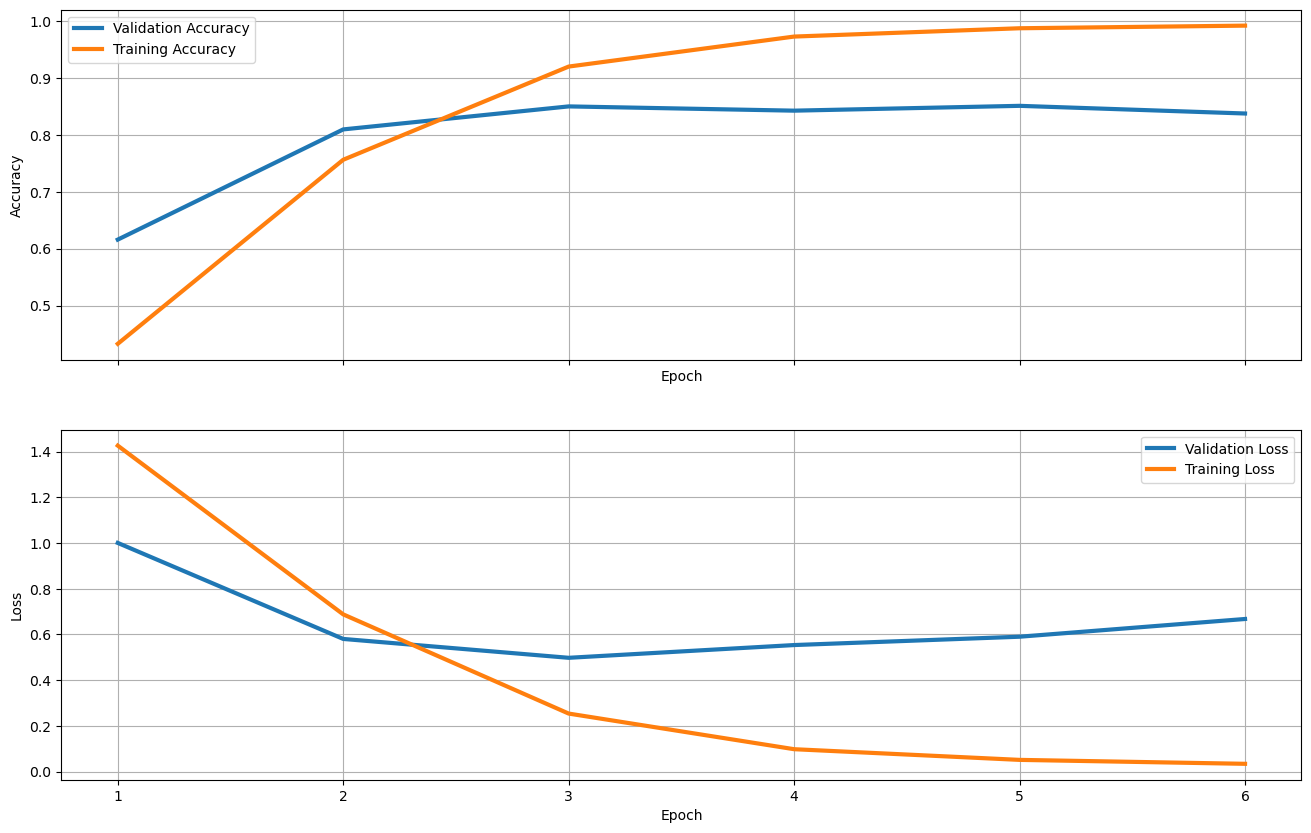

In [46]:
plot_results(history_nn)

In [47]:
# Save the model
model_nn.save('models/nn.h5')

/Users/raydi/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Recurent Neural Network (LSTM)

In [48]:
# Model Definition with LSTM and Embedding in the first layer
embedding_dim = 50

model_lstm = tf.keras.Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(32)),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(num_label, activation='softmax')
])

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 50)           500000    
                                                                 
 bidirectional_4 (Bidirecti  (None, 100, 128)          58880     
 onal)                                                           
                                                                 
 dropout_41 (Dropout)        (None, 100, 128)          0         
                                                                 
 bidirectional_5 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout_42 (Dropout)        (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 16)               

In [49]:
# Training
num_epochs = 25

history_lstm = model_lstm.fit(
    train_padded, 
    train_labels_encoded, 
    epochs=num_epochs, 
    batch_size=32, 
    validation_data=(test_padded, test_labels_encoded),
    callbacks=[early_stopping]
)

Epoch 1/25
500/500 [==============================] - 55s 94ms/step - loss: 1.2462 - accuracy: 0.5017 - val_loss: 0.7651 - val_accuracy: 0.6705
Epoch 2/25
500/500 [==============================] - 41s 82ms/step - loss: 0.5585 - accuracy: 0.7945 - val_loss: 0.4181 - val_accuracy: 0.8650
Epoch 3/25
500/500 [==============================] - 43s 86ms/step - loss: 0.3134 - accuracy: 0.8979 - val_loss: 0.3501 - val_accuracy: 0.8860
Epoch 4/25
500/500 [==============================] - 48s 96ms/step - loss: 0.2043 - accuracy: 0.9360 - val_loss: 0.3214 - val_accuracy: 0.9025
Epoch 5/25
500/500 [==============================] - 41s 81ms/step - loss: 0.1484 - accuracy: 0.9534 - val_loss: 0.3021 - val_accuracy: 0.9050
Epoch 6/25
500/500 [==============================] - 40s 80ms/step - loss: 0.1202 - accuracy: 0.9618 - val_loss: 0.3142 - val_accuracy: 0.8995
Epoch 7/25
500/500 [==============================] - 40s 80ms/step - loss: 0.1011 - accuracy: 0.9679 - val_loss: 0.3130 - val_accuracy:

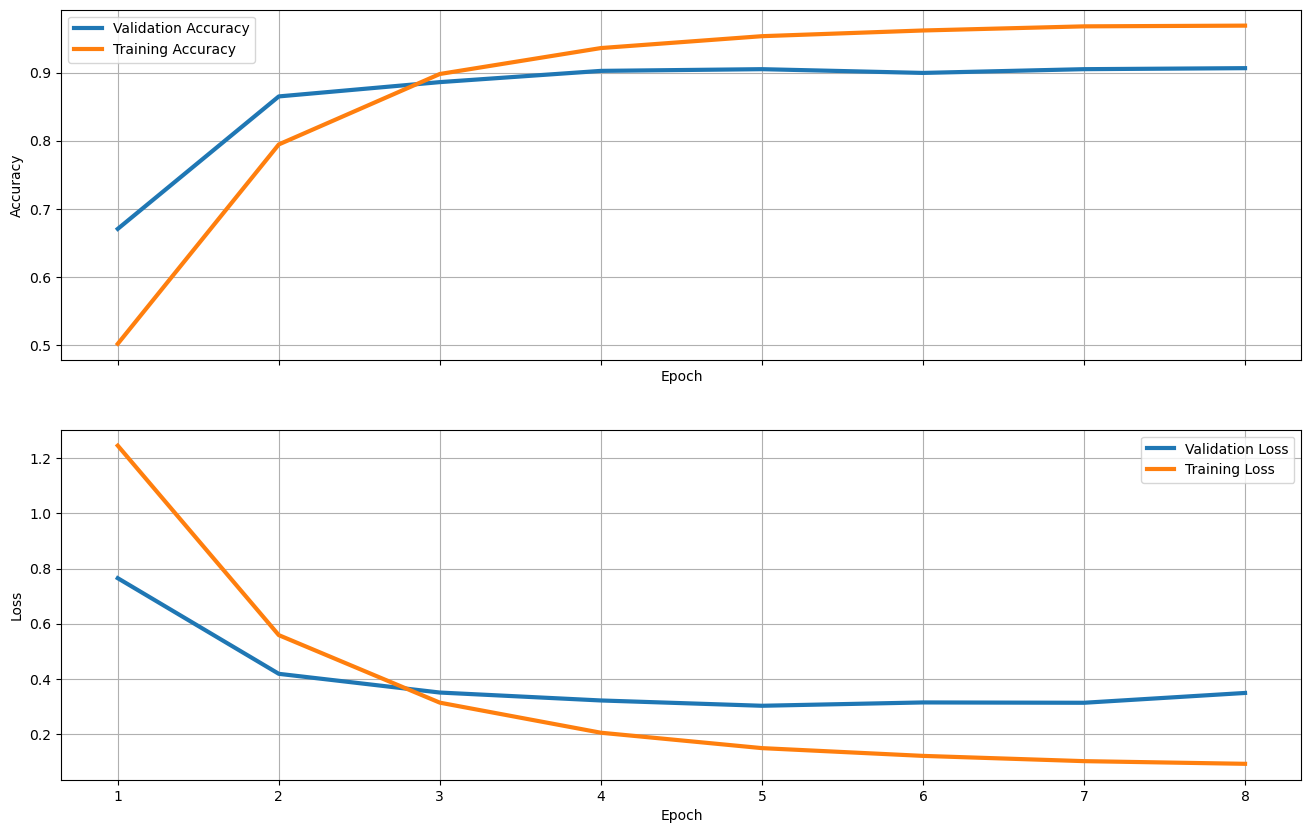

In [50]:
plot_results(history_lstm)

In [51]:
# Save the model
model_lstm.save('models/lstm.h5')

/Users/raydi/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Fine-tuned Transformer

In [20]:
from transformers import (
    BertTokenizer,
    TFBertModel,
)

In [21]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model  = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [30]:
train_inputs = []
train_masks = []

for sentence in train_sentences:
    encoded_sentence = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='tf'
    )
    train_inputs.append(encoded_sentence['input_ids'])
    train_masks.append(encoded_sentence['attention_mask'])

train_inputs = tf.concat(train_inputs, axis=0)
train_masks = tf.concat(train_masks, axis=0)

test_inputs = []
test_masks = []

for sentence in test_sentences:
    encoded_sentence = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='tf'
    )
    test_inputs.append(encoded_sentence['input_ids'])
    test_masks.append(encoded_sentence['attention_mask'])

test_inputs = tf.concat(test_inputs, axis=0)
test_masks = tf.concat(test_masks, axis=0)

print(train_inputs.shape, train_masks.shape)
print(test_inputs.shape, test_masks.shape)

(16000, 100) (16000, 100)
(2000, 100) (2000, 100)


In [22]:
bert_model.trainable = False

In [23]:
input_ids = tf.keras.Input(shape=(max_length,), dtype=tf.int32)

bert_output = bert_model(input_ids)

# logits_output = tf.expand_dims(bert_output.logits, axis=1)

net = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(64, return_sequences=True)
)(bert_output[0])

net = tf.keras.layers.Dropout(0.3)(net)

net = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(net)

net = tf.keras.layers.Dropout(0.3)(net)

net = tf.keras.layers.Dense(32, activation="relu")(net)

output = tf.keras.layers.Dense(num_label, activation="softmax")(net)

model = tf.keras.Model(inputs=input_ids, outputs=output)

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPo   109482240 
 )                           olingAndCrossAttentions             
                             (last_hidden_state=(Non             
                             e, 100, 768),                       
                              pooler_output=(None, 7             
                             68),                                
                              past_key_values=None,              
                             hidden_states=None, att             
                             entions=None, cross_att             
                             entions=None)                       
                                                             

In [25]:
model.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

In [28]:
hist = model.fit(
    train_padded,
    train_labels_encoded,
    epochs=10,
    batch_size=128,
    validation_data=(test_padded, test_labels_encoded),
)

Epoch 1/10
125/125 [==============================] - 515s 4s/step - loss: 1.5904 - accuracy: 0.3249 - val_loss: 1.5606 - val_accuracy: 0.3475
Epoch 2/10
125/125 [==============================] - 490s 4s/step - loss: 1.5842 - accuracy: 0.3274 - val_loss: 1.5597 - val_accuracy: 0.3475
Epoch 3/10
125/125 [==============================] - 529s 4s/step - loss: 1.5829 - accuracy: 0.3254 - val_loss: 1.5596 - val_accuracy: 0.3475
Epoch 4/10
125/125 [==============================] - 533s 4s/step - loss: 1.5827 - accuracy: 0.3259 - val_loss: 1.5604 - val_accuracy: 0.3475
Epoch 5/10
125/125 [==============================] - 505s 4s/step - loss: 1.5820 - accuracy: 0.3291 - val_loss: 1.5606 - val_accuracy: 0.3475
Epoch 6/10
125/125 [==============================] - 345s 3s/step - loss: 1.5816 - accuracy: 0.3316 - val_loss: 1.5589 - val_accuracy: 0.3475
Epoch 7/10
125/125 [==============================] - 468s 4s/step - loss: 1.5811 - accuracy: 0.3307 - val_loss: 1.5611 - val_accuracy: 0.3475

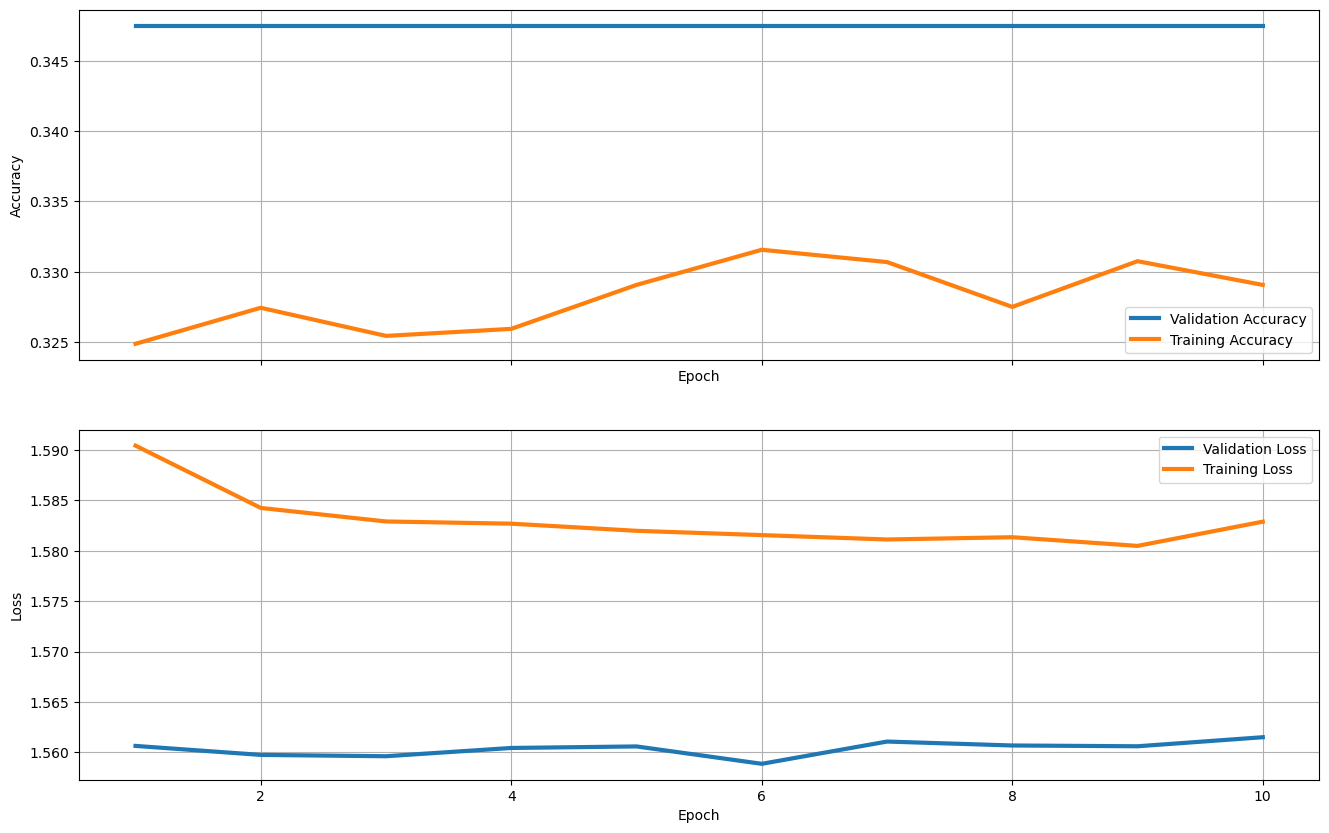

In [29]:
plot_results(hist)

In [21]:
model.save('models/bert.h5')